# More Advanced Techniques (and Architectures)
We have thus far studied a number of convolutional networks for performing classification, specifically using the Fashion MNIST dataset. However, as the classification problem becomes more complicated, it will require more complicated architectures and more involved methods for regularizing the data. For instance, object recognition requires more knowledge than simple handwriting digits (as in the case of recognizing shirts in Fashion MNIST). The complexities of the picture are more varied, color has an influence, and much more. Therefore, the simple convolutions that we used before might not be expressive enough without a number of additional layers. 

Let's try some of these techniques with Tiny Imagenet (a subset of ImageNet Data with 64x64 sized images and 200 classes). Some of these concepts we have already talked about, such as different initializations and different regularizers. Namely, we will cover these concepts:

- Expansion
- Initialization
- Parallel Pathways
- Building Blocks from More Advanced Networks (bypass, branching, etc.)

![resnet](PDF_Slides/CNN_Summary.png)

After going through this tutorial, you will have an understanding of how to use some of the more advanced techniques--however we are limited here by the hardware and time in lecture. Many modern architectures can take days/weeks to train and are extremely deep (look at the 100+ layers of ResNet-112). However, some of the architectures from ~2013 and ~2014 are manageable to investigate and take only a few hours to train. We will cover a few concepts for getting models up and running, and maybe even use more some complicated architectures. Let's get started! 

This is also an excellent tutorial with even more information than I am showing for the fine tuning techniques:
- https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

# model creation imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Concatenate, Add, Reshape, Input

# utility imports
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# augmentation imports
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomContrast, RandomBrightness

# other plotting and evaluation imports
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

print(tf.config.list_physical_devices('GPU'))
print('Keras:', keras.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras: 3.5.0


In [3]:
# Utility functions for summarizing outputs from models
def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='training')
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='training')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend()
    plt.show()


def summarize_models(nets, ds, fig_size = (15,5) ):
    plt.figure(figsize=fig_size)

    num_plots = len(nets)
    for i, net in enumerate(nets):
        # get output and labels for the model, as numpy
        y_test, yhat = [], []
        for features, batch_labels in ds:
            y_test.append(batch_labels.numpy())
            yhat.append(np.argmax(net.predict(features, verbose=0), axis=1).squeeze())
        y_test = np.concatenate(y_test, axis=0)
        yhat = np.concatenate(yhat, axis=0)
        
        acc = mt.accuracy_score(y_test,yhat)*100
        cm  = mt.confusion_matrix(y_test,yhat)
        cm  = cm/(np.sum(cm,axis=1)[:,np.newaxis]+1e-6)
        plt.subplot(1,num_plots,i+1)
        sns.heatmap(cm, annot=False)
        plt.title(f'{net.name}:{acc:.2f}')

    plt.show()

Now let's load in a more diverse, harder to classify dataset.

**Labels**
We will start to investigate performance using the Tiny ImageNet dataset. This dataset consists of 200 classes from original ImageNet dataset. Each class is having 500 train images, 50 validation images. So 100,000 images for training and 10,000 images for validation.

The dataset is surprisingly difficult to classify upon, with most models achieving top-1 accuracies of less than 50%. A list of models and performances is given at the link below. One aspect of difficulty is that one cannot use transfer learning from large models, becasue these models are typically trained on the original ImageNet data (i.e., these data appear in ImageNet, so transfer learning is not advisable). As such, this provides a challenging test case to learn from. 
- https://github.com/meet-minimalist/TinyImageNet-Benchmarks

You can find "evidence" of strong performance on TinyImagenet, for example here: https://arxiv.org/html/2505.08259v1. In this paper, they used ViT (which has the ImageNet training set as part of its original training). It acheived an amazing accuracy > 90%. All they had to do was train and test on the same data. 

Each training and test example is assigned to one of 200 labels. For instance here is a small set of sample labels.
- 'n02085620': 'Chihuahua',
- 'n02094433': 'Yorkshire',
- 'n02099601': 'golden',
- 'n02099712': 'Labrador',
- 'n02106662': 'German',
- 'n02113799': 'standard',
- 'n02123045': 'tabby,',
- 'n02123394': 'Persian',
- 'n02124075': 'Egyptian',
- 'n02125311': 'cougar,',
- 'n02129165': 'lion,',
- 'n02132136': 'brown',
- 'n02165456': 'ladybug,',
- ... and many other classes. 

In [4]:
import os
import struct
import numpy as np

# load train data
ds_train = tf.keras.utils.image_dataset_from_directory(
    'large_data/tiny-imagenet-200/train',
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='int',   # Labels will be integers (0, 1, 2...)
    image_size=(64, 64), # Resize images 
    validation_split=0.2,
    subset='training',
    seed=42             # Seed for reproducibility
)

# save list of class names
class_names = ds_train.class_names

dict_class_names_to_int = {}
for i, cls in enumerate(class_names):
    dict_class_names_to_int[cls] = i

# load testing data
ds_test = tf.keras.utils.image_dataset_from_directory(
    'large_data/tiny-imagenet-200/train',
    labels='inferred',  # Infer labels from subdirectory names
    label_mode='int',   # Labels will be integers (0, 1, 2...)
    image_size=(64, 64), # Resize images 
    validation_split=0.2,
    subset='validation',
    seed=42             # Seed for reproducibility
)

def normalize_image(image, label):
    # Scale pixel values to [0, 1]
    image = image / 255.0
    return image, label

ds_train = ds_train.map(normalize_image)
ds_test = ds_test.map(normalize_image)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.prefetch(tf.data.AUTOTUNE)

Found 100000 files belonging to 200 classes.
Using 80000 files for training.


2025-11-17 08:03:37.322922: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-17 08:03:37.322970: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-17 08:03:37.322982: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-17 08:03:37.323155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-17 08:03:37.323166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 100000 files belonging to 200 classes.
Using 20000 files for validation.


In [5]:
NUM_CLASSES = len(class_names)
print(NUM_CLASSES)

dict_class_names_to_description = {}
with open('large_data/tiny-imagenet-200/words.txt', 'r') as file:
    # Read each line from the file
    for line in file:
        vals = line.strip().split()
        key = vals[0]
        if key in class_names:
            dict_class_names_to_description[key] = vals[1]
            
dict_class_names_to_description

200


{'n01443537': 'goldfish,',
 'n01629819': 'European',
 'n01641577': 'bullfrog,',
 'n01644900': 'tailed',
 'n01698640': 'American',
 'n01742172': 'boa',
 'n01768244': 'trilobite',
 'n01770393': 'scorpion',
 'n01774384': 'black',
 'n01774750': 'tarantula',
 'n01784675': 'centipede',
 'n01855672': 'goose',
 'n01882714': 'koala,',
 'n01910747': 'jellyfish',
 'n01917289': 'brain',
 'n01944390': 'snail',
 'n01945685': 'slug',
 'n01950731': 'sea',
 'n01983481': 'American',
 'n01984695': 'spiny',
 'n02002724': 'black',
 'n02056570': 'king',
 'n02058221': 'albatross,',
 'n02074367': 'dugong,',
 'n02085620': 'Chihuahua',
 'n02094433': 'Yorkshire',
 'n02099601': 'golden',
 'n02099712': 'Labrador',
 'n02106662': 'German',
 'n02113799': 'standard',
 'n02123045': 'tabby,',
 'n02123394': 'Persian',
 'n02124075': 'Egyptian',
 'n02125311': 'cougar,',
 'n02129165': 'lion,',
 'n02132136': 'brown',
 'n02165456': 'ladybug,',
 'n02190166': 'fly',
 'n02206856': 'bee',
 'n02226429': 'grasshopper,',
 'n02231487

Training
Image size: (64, 64, 3) , Classes: 200


2025-11-17 08:03:45.280116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


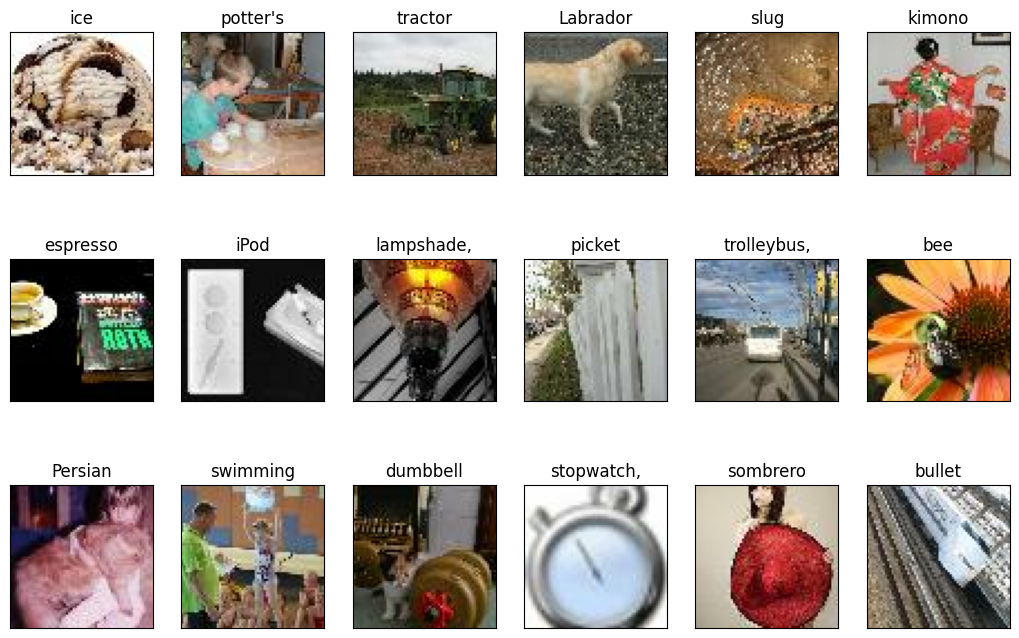

Validation
Image size: (64, 64, 3) , Classes: 200


2025-11-17 08:03:45.784173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


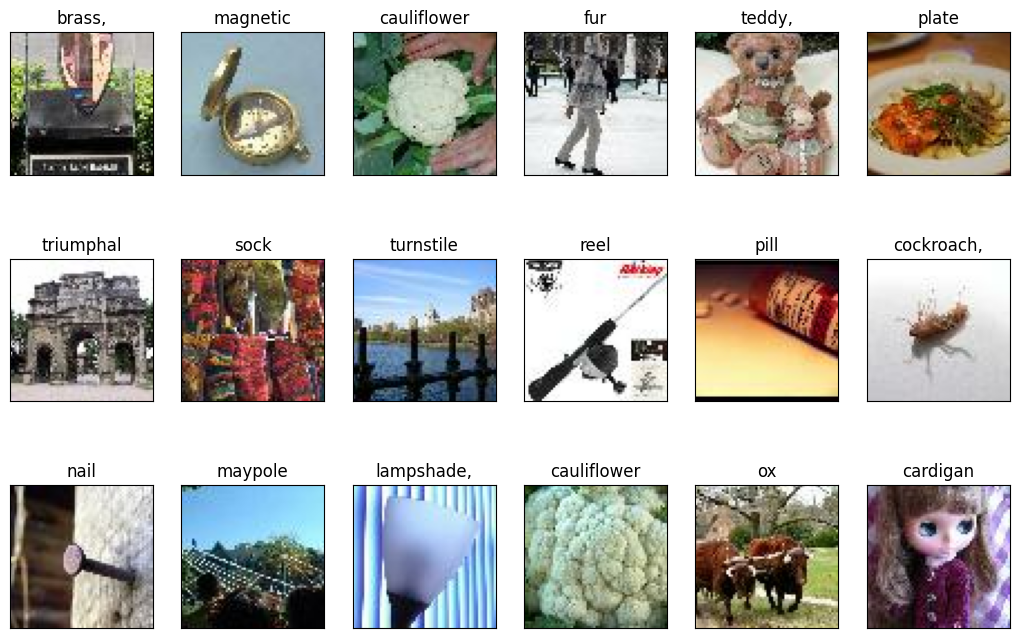

In [6]:
# a helper plotting function
def plot_gallery(ds, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    [(img_sample_tf, label_sample_tf)] = ds.take(1)
    images = img_sample_tf.numpy()
    
    img_wh = img_sample_tf[0].shape[0] # get the width and height for the image
    print('Image size:',img_sample_tf[0].shape,', Classes:',200)
    titles = [dict_class_names_to_description[class_names[x]] for x in label_sample_tf.numpy()] 
    
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze())
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

    plt.show()

print('Training')
plot_gallery(ds_train, 64, 64) 
print('Validation')
plot_gallery(ds_test, 64, 64) 

## Starting simple
Let's first start by using data expansion with an architecture similar to AlexNet.

In [7]:
%%time 

cnn = Sequential(name='AlexNet')

cnn.add( Input([64,64,3]) )

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same', 
                activation='relu')) 

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same', 
                activation='relu')) 
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(filters=256,
                kernel_size=(5,5), 
                padding='same', 
                activation='relu')) 
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(filters=256,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) 
cnn.add(MaxPooling2D(pool_size=(3, 3)))
    

# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

opt = keras.optimizers.Adam(beta_1=.9,beta_2=.999,learning_rate = 0.0001)

# Let's train the model 
cnn.compile(loss='sparse_categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer=opt, # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn.summary()

Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 96)     │     1,115,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,245,480 (12.38 MB)

 Trainable params: 3,245,480 (12.38 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 451 ms, sys: 33 ms, total: 484 ms
Wall time: 174 ms


Epoch 1/10


2025-11-14 08:09:20.200425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 204s 81ms/step - accuracy: 0.0088 - loss: 5.2216 - val_accuracy: 0.0287 - val_loss: 4.9303
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 210s 84ms/step - accuracy: 0.0320 - loss: 4.8948 - val_accuracy: 0.0717 - val_loss: 4.5468
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 218s 87ms/step - accuracy: 0.0649 - loss: 4.5710 - val_accuracy: 0.1057 - val_loss: 4.2747
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 224s 90ms/step - accuracy: 0.1015 - loss: 4.2797 - val_accuracy: 0.1401 - val_loss: 4.0208
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 224s 89ms/step - accuracy: 0.1355 - loss: 4.0241 - val_accuracy: 0.1722 - val_loss: 3.8332
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 237s 95ms/step - accuracy: 0.1687 - loss: 3.7916 - val_accuracy: 0.1959 - val_loss: 3.6697
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 244s 97ms/step - accuracy: 0.1990 - loss: 3.5915 - val_accuracy: 0.2001 - val_loss: 3.6463
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 223s 89ms/step - accuracy: 0.2328 - lo

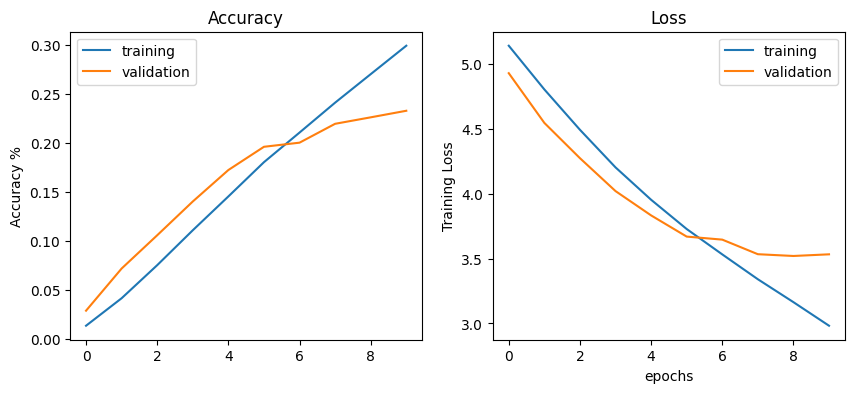

In [8]:
# now fit with random augmentations applied during training only
history = cnn.fit(ds_train, 
                   epochs=10, verbose=1,
                   validation_data=ds_test
                  )
# use custom plotting functions
plot_history(history)

2025-11-14 08:46:51.443047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


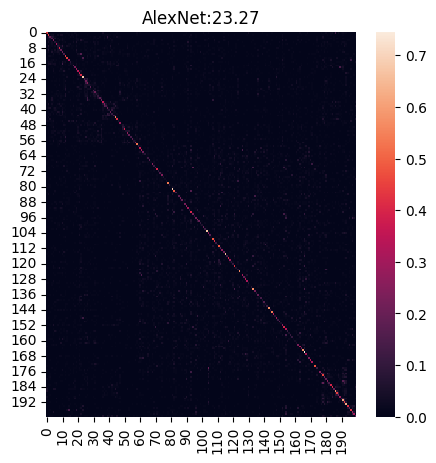

In [9]:
summarize_models([cnn], ds_test, fig_size=(5,5))

_____
The above AlexNet model is not too bad, but we might need to be more aggressive with preventing overfitting. To help, we will use more Dropout, Image Augmentations, and some L2 weight regularizations per layer.

Moreover, we need to run for more epochs. But how can we know if we converged? Here we can incorporate Early Stopping using one of the keras calback functions.

Let's try these techniques with the AlexNet model from before.

In [10]:



# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn2 = Sequential(name='AlexNet_Aug')

cnn2.add( Input([64,64,3]) )

# add in augmentations directly
cnn2.add( RandomFlip("horizontal") ) # flip horizontally
cnn2.add( RandomRotation(0.05) ) # rotate by 5%
cnn2.add( RandomTranslation(height_factor=0.1, width_factor=0.1) ) # move by 10%
cnn2.add( RandomBrightness(factor=0.1, value_range=(0.0, 1.0)) ) # add some to the mean
cnn2.add( RandomContrast(0.1) ) # add or decrease contrast

cnn2.add(Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6), 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn2.add(Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

cnn2.add(Conv2D(filters=256,
                kernel_size=(5,5), 
                padding='same', 
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-5),
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

cnn2.add(Conv2D(filters=256,
                kernel_size=(3,3), 
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-5),
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(3, 3)))
    

# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(1024, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4)))
cnn2.add(Dense(512, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4)))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(NUM_CLASSES, activation='softmax', 
              kernel_initializer='glorot_uniform'
              ))

opt = keras.optimizers.Adam(beta_1=.9,beta_2=.999,learning_rate = 0.0001)

# Let's train the model 
cnn2.compile(loss='sparse_categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer=opt, 
              metrics=['accuracy'])

cnn2.summary()

Model: "AlexNet_Aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 64, 64, 3)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 96)     │     1,115,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,245,480 (12.38 MB)

 Trainable params: 3,245,480 (12.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 262s 104ms/step - accuracy: 0.0102 - loss: 5.5025 - val_accuracy: 0.0378 - val_loss: 5.0920
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 268s 107ms/step - accuracy: 0.0385 - loss: 5.0689 - val_accuracy: 0.0798 - val_loss: 4.6737
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 260s 104ms/step - accuracy: 0.0665 - loss: 4.7407 - val_accuracy: 0.0977 - val_loss: 4.4949
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 277s 111ms/step - accuracy: 0.0893 - loss: 4.5213 - val_accuracy: 0.1180 - val_loss: 4.3565
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 270s 108ms/step - accuracy: 0.1150 - loss: 4.3430 - val_accuracy: 0.1480 - val_loss: 4.1053
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 286s 114ms/step - accuracy: 0.1333 - loss: 4.1958 - val_accuracy: 0.1388 - val_loss: 4.1662
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 300s 120ms/step - accuracy: 0.1526 - loss: 4.0705 - val_accuracy: 0.1778 - val_loss: 3.9179
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 261s 104ms/s

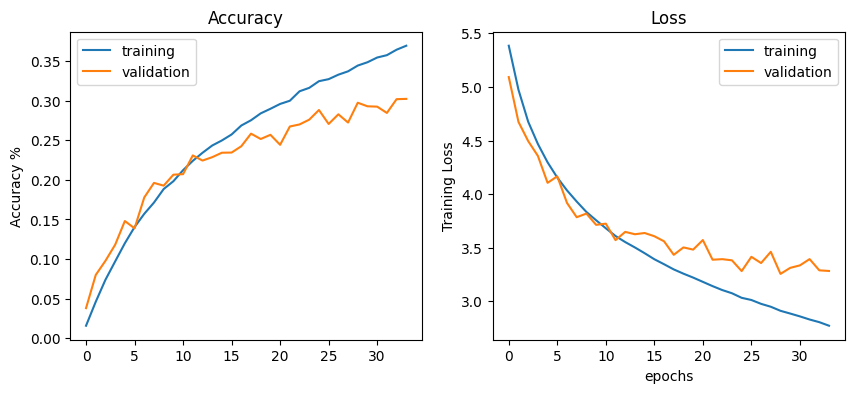

In [11]:
# now fit with random augmentations applied during training only
history = cnn2.fit(ds_train,  
           epochs=100, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
        )
# use custom plotting functions
plot_history(history)

2025-11-14 11:31:47.476167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-14 11:32:05.456523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


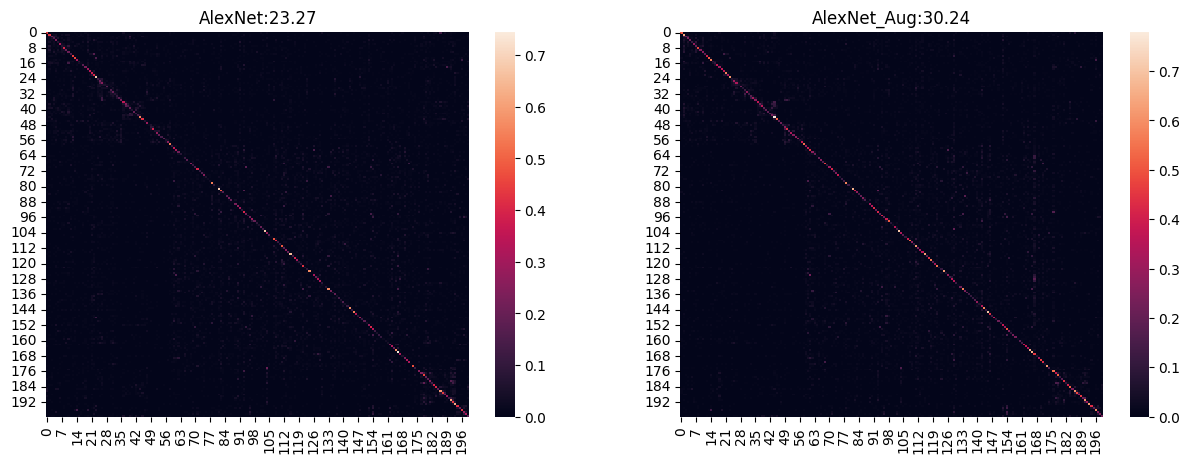

In [12]:

summarize_models([cnn, cnn2], ds_test)

# Parallel Pathways
Now lets do the exact same thing, but with blocks that process the data in multiple pathways, like Inception. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

Reminder of Differences from Sequential and Functional APIs:
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

Because we want to define parallel paths in the network, we can also use sequential models as if they were custom layers. That is, we can define the branches in a parallel path using separate sequential models. Then, we simply use the model in the Functional API like a layer. For example:

```python
    # Define subnetwork
    sequential_branch = Sequential([
        Dense(64, activation='relu', input_shape=(16,)),
        Dropout(0.3),
        Dense(32, activation='relu')
    ], name='sequential_sub_network')

    # Define inputs for the overall Functional model
    main_input = Input(shape=(32,), name='main_input')

    # Process the main input through some initial layers
    x = Dense(128, activation='relu')(main_input)

    # Branch off and feed a part of the network through the Sequential model
    sequential_output = sequential_branch(x[:, :16]) # Assuming you want to feed a slice

    # Continue building the Functional model, combining outputs if needed
    combined_output = concatenate([x, sequential_output])
    final_output = Dense(1, activation='sigmoid', name='final_output')(combined_output)

    # Create the complete Functional model
    hybrid_model = models.Model(inputs=main_input, outputs=final_output)
```

In [13]:
%%time

# we can also use sequential like a function builder, 
parallel_3x3a = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=128,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])

parallel_3x3multa = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=64,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=64,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])

conv_1x1a = Conv2D(filters=64,kernel_size=(1,1), padding='same',
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-6))

# we can also use sequential like a function builder, 
parallel_3x3b = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=128,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])

parallel_3x3multb = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=64,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=64,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])

conv_1x1b = Conv2D(filters=64,kernel_size=(1,1), padding='same',
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-6))


input_holder = Input(shape=(64, 64, 3))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

x= Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6), 
                activation='relu')(x)

# no max pool before next conv layer!!
x = Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')(x)

# now save this tensor to use in mutliple branches
input_conv = MaxPooling2D(pool_size=(2, 2),  name='branch_point1')(x)

# now place into parallel input branches
branches = []
x = conv_1x1a(input_conv)
branches.append(x)
x = parallel_3x3a(input_conv)
branches.append(x)
x = parallel_3x3multa(input_conv)
branches.append(x)
# that's it, we just need to average the results
x = Concatenate(axis=-1,name='ens_concat1')(branches)

x = Conv2D(filters=128,
                kernel_size=(1,1), 
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')(x)

input_conv = MaxPooling2D(pool_size=(2, 2),  name='branch_point2')(x)

# now place into parallel input branches
branches = []
x = conv_1x1b(input_conv)
branches.append(x)
x = parallel_3x3b(input_conv)
branches.append(x)
x = parallel_3x3multb(input_conv)
branches.append(x)
# that's it, we just need to average the results
x = Concatenate(axis=-1,name='ens_concat2')(branches)

x = Conv2D(filters=128,
                kernel_size=(1,1), 
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')(x)

# add one layer on flattened output
x = Flatten()(x)
x = Dense(1024, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dense(512, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dropout(0.5)(x) # add some dropout for regularization!

x = Dense(NUM_CLASSES, activation='softmax', 
              kernel_initializer='glorot_uniform'
              )(x)

#   Functional API:
cnn_path = Model(inputs=input_holder, outputs=x, name='Inception')

opt = keras.optimizers.Adam(beta_1=.9,beta_2=.999,learning_rate = 0.0001)

# Let's train the model 
cnn_path.compile(loss='sparse_categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer=opt,
              metrics=['accuracy'])

cnn_path.summary()


Model: "Inception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 64, 64, 3) │          0 │ input_layer_2[0]… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 64, 64, 3) │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 64, 64, 3) │          0 │ random_rotation_… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness_1 │ (None, 64, 64, 3) │          0 │ random_translati… │
│ (RandomBrightness)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 64, 64, 3) │          0 │ random_brightnes… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     34,944 │ random_contrast_… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │  1,115,232 │ conv2d_20[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_point1       │ (None, 8, 8, 96)  │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 64)  │      6,208 │ branch_point1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 128) │     40,096 │ branch_point1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 8, 8, 64)  │     58,528 │ branch_point1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ens_concat1         │ (None, 8, 8, 256) │          0 │ conv2d_13[0][0],  │
│ (Concatenate)       │                   │            │ sequential[0][0], │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ ens_concat1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_point2       │ (None, 4, 4, 128) │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 4, 4, 64)  │      8,256 │ branch_point2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 4, 4, 128) │     41,120 │ branch_point2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,155,304 (15.85 MB)

 Trainable params: 4,155,304 (15.85 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 137 ms, sys: 66.9 ms, total: 204 ms
Wall time: 248 ms


Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 357s 141ms/step - accuracy: 0.0116 - loss: 5.5683 - val_accuracy: 0.0477 - val_loss: 5.0602
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 347s 139ms/step - accuracy: 0.0430 - loss: 5.0778 - val_accuracy: 0.0799 - val_loss: 4.7342
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 346s 138ms/step - accuracy: 0.0721 - loss: 4.7612 - val_accuracy: 0.1052 - val_loss: 4.4993
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 352s 141ms/step - accuracy: 0.0968 - loss: 4.5338 - val_accuracy: 0.1260 - val_loss: 4.3265
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 352s 141ms/step - accuracy: 0.1215 - loss: 4.3637 - val_accuracy: 0.1427 - val_loss: 4.2279
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 353s 141ms/step - accuracy: 0.1405 - loss: 4.2102 - val_accuracy: 0.1306 - val_loss: 4.3306
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 364s 146ms/step - accuracy: 0.1578 - loss: 4.0952 - val_accuracy: 0.1766 - val_loss: 3.9599
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 372s 149ms/s

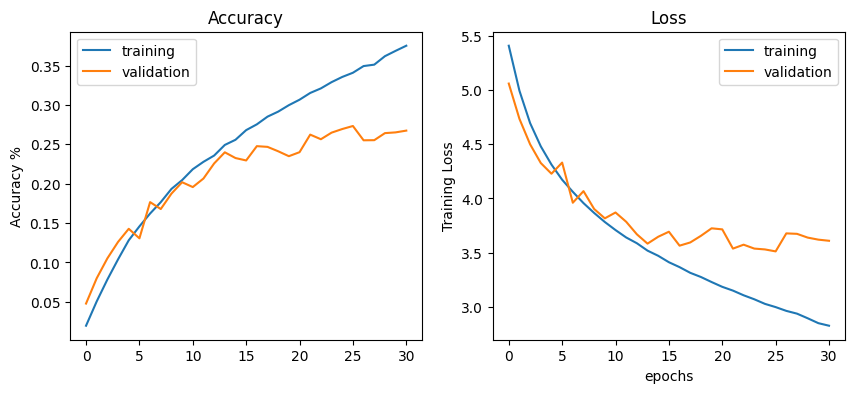

CPU times: user 2h 9min 8s, sys: 57min 57s, total: 3h 7min 6s
Wall time: 3h 18min 22s


In [14]:
%%time

# now fit with random augmentations applied during training only
history = cnn_path.fit(ds_train,  
           epochs=100, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
        )
# use custom plotting functions
plot_history(history)

2025-11-14 14:50:47.863803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-14 14:51:05.740270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-14 14:51:23.618039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


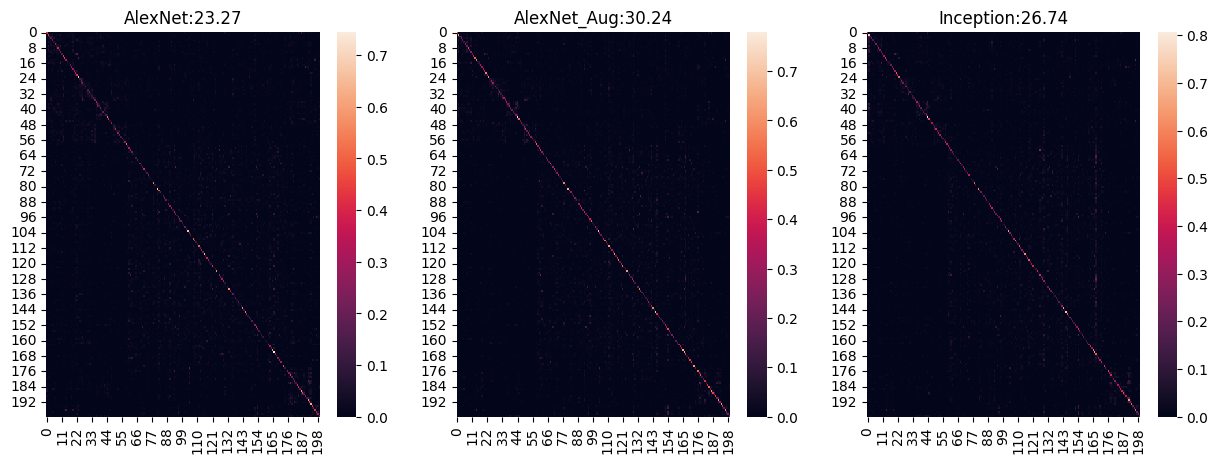

In [15]:
summarize_models([cnn, cnn2, cnn_path], ds_test)

___
# Adding ResNet Style Blocks
Okay, so now lets try a trick from 2016. The ResNet-Style Bypass is described in the following:
![resnet](https://cdn-images-1.medium.com/max/1600/0*0r0vS8myiqyOb79L.jpg)

In [7]:
# now lets use a residual architecture
# We will also use ReLU where approriate and drop out 

concat_filt_size = 128

residual_3x3a = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=32,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=concat_filt_size,kernel_size=(1,1),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])

residual_3x3b = keras.Sequential([
        Conv2D(filters=32, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=32,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)),
        Conv2D(filters=concat_filt_size,kernel_size=(3,3),padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))
    ])


input_holder = Input(shape=(64, 64, 3))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

x= Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6), 
                activation='relu')(x)

# no max pool before next conv layer!!
x = Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')(x)

# now save this tensor to use in mutliple branches
x = MaxPooling2D(pool_size=(2, 2),  name='branch_point1')(x)

x_split = Conv2D(filters=concat_filt_size, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))(x)

x = residual_3x3a(x_split)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_3x3b(x_split)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

# add one layer on flattened output
x = Flatten()(x)
x = Dense(1024, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dense(512, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dropout(0.5)(x) # add some dropout for regularization!

x = Dense(NUM_CLASSES, activation='softmax', 
              kernel_initializer='glorot_uniform'
              )(x)

#   Functional API:
cnn_res = Model(inputs=input_holder, outputs=x, name='ResNet')

opt = keras.optimizers.Adam(beta_1=.9,beta_2=.999,learning_rate = 0.0001)

# Let's train the model 
cnn_res.compile(loss='sparse_categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer=opt,
              metrics=['accuracy'])

cnn_res.summary()

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 64, 64, 3) │          0 │ random_flip[0][0] │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 64, 64, 3) │          0 │ random_rotation[… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness   │ (None, 64, 64, 3) │          0 │ random_translati… │
│ (RandomBrightness)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 64, 64, 3) │          0 │ random_brightnes… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     34,944 │ random_contrast[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  1,115,232 │ conv2d_6[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_point1       │ (None, 8, 8, 96)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 128) │     12,416 │ branch_point1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 128) │     17,600 │ conv2d_8[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 128) │          0 │ sequential[0][0], │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8, 8, 128) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 4, 4, 128) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4, 4, 128) │     50,368 │ max_pooling2d[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 4, 4, 128) │          0 │ sequential_1[0][… │
│                     │                   │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 4, 128) │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 2,383,272 (9.09 MB)

 Trainable params: 2,383,272 (9.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-11-17 08:31:01.339735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 299s 118ms/step - accuracy: 0.0123 - loss: 5.6989 - val_accuracy: 0.0369 - val_loss: 5.1778
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 299s 119ms/step - accuracy: 0.0320 - loss: 5.1871 - val_accuracy: 0.0597 - val_loss: 4.8723
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 314s 126ms/step - accuracy: 0.0525 - loss: 4.9230 - val_accuracy: 0.0898 - val_loss: 4.6285
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 321s 128ms/step - accuracy: 0.0694 - loss: 4.7442 - val_accuracy: 0.1025 - val_loss: 4.4804
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 333s 133ms/step - accuracy: 0.0840 - loss: 4.6059 - val_accuracy: 0.1064 - val_loss: 4.4514
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 327s 131ms/step - accuracy: 0.0971 - loss: 4.4982 - val_accuracy: 0.1142 - val_loss: 4.3857
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 324s 130ms/step - accuracy: 0.1091 - loss: 4.3987 - val_accuracy: 0.1276 - val_loss: 4.2866
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 332s 133ms/step - accura

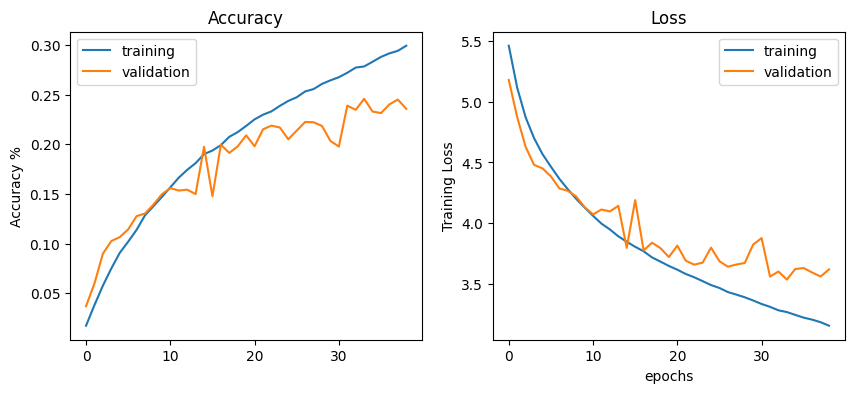

CPU times: user 2h 12min 16s, sys: 1h 21s, total: 3h 12min 38s
Wall time: 3h 52min 2s


In [10]:
%%time

model_checkpoint = ModelCheckpoint(
    'large_data/models/res_net.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# now fit with random augmentations applied during training only
history = cnn_res.fit(ds_train,  
           epochs=100, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_checkpoint]
        )
# use custom plotting functions
plot_history(history)

2025-11-17 12:23:20.223102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


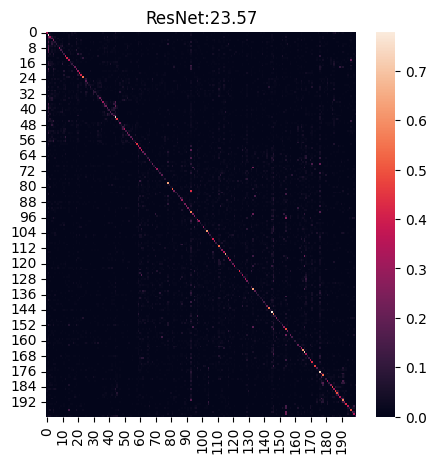

In [11]:
summarize_models([cnn_res], ds_test, fig_size=(5,5))

2025-11-17 12:24:27.809034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


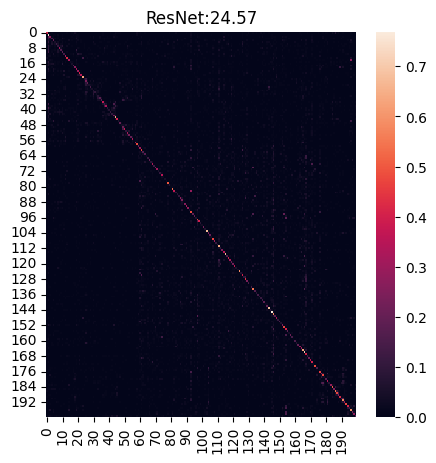

In [12]:
from tensorflow.keras.models import load_model
cnn_res_best = load_model('large_data/models/res_net.keras')
summarize_models([cnn_res_best], ds_test, fig_size=(5,5))

In [8]:
# Xception style architecture

# here we use the separable convolution
concat_filt_size = 128

xcept_3x3a = keras.Sequential([
        SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depth_multiplier = 1, activation='relu'),
        SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depth_multiplier = 2, activation='relu'),
        SeparableConv2D(filters=concat_filt_size, kernel_size=(3,3), padding='same', depth_multiplier = 1, activation='relu')
    ])

xcept_3x3b = keras.Sequential([
        SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depth_multiplier = 1, activation='relu'),
        SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', depth_multiplier = 2, activation='relu'),
        SeparableConv2D(filters=concat_filt_size, kernel_size=(3,3), padding='same', depth_multiplier = 1, activation='relu')
    ])


input_holder = Input(shape=(64, 64, 3))

# add in augmentations directly
x = RandomFlip("horizontal")(input_holder) # flip horizontally
x = RandomRotation(0.05)(x) # rotate by 5%
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # move by 10%
x = RandomBrightness(factor=0.1, value_range=(0.0, 1.0))(x) # add some to the mean
x = RandomContrast(0.1)(x) # add or decrease contrast

x= Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6), 
                activation='relu')(x)

# no max pool before next conv layer!!
x = Conv2D(filters=96,
                kernel_size=(11,11), 
                strides=(2,2), # add some initial downsampling
                padding='same',
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(1e-6),
                activation='relu')(x)

# now save this tensor to use in mutliple branches
x = MaxPooling2D(pool_size=(2, 2),  name='branch_point1')(x)

x_split = Conv2D(filters=concat_filt_size, kernel_size=(1,1), padding='same', 
                kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5))(x)

x = xcept_3x3a(x_split)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x_split = MaxPooling2D(pool_size=(2, 2))(x)

x = xcept_3x3b(x_split)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

# add one layer on flattened output
x = Flatten()(x)
x = Dense(1024, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dense(512, activation='relu', 
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(1e-4))(x)

x = Dropout(0.5)(x) # add some dropout for regularization!

x = Dense(NUM_CLASSES, activation='softmax', 
              kernel_initializer='glorot_uniform'
              )(x)

#   Functional API:
cnn_xcep = Model(inputs=input_holder, outputs=x, name='Xception')

opt = keras.optimizers.Adam(beta_1=.9,beta_2=.999,learning_rate = 0.0001)

# Let's train the model 
cnn_xcep.compile(loss='sparse_categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer=opt,
              metrics=['accuracy'])

cnn_xcep.summary()

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 64, 64, 3) │          0 │ input_layer_3[0]… │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 64, 64, 3) │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 64, 64, 3) │          0 │ random_rotation_… │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness_1 │ (None, 64, 64, 3) │          0 │ random_translati… │
│ (RandomBrightness)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 64, 64, 3) │          0 │ random_brightnes… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     34,944 │ random_contrast_… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │  1,115,232 │ conv2d_9[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch_point1       │ (None, 8, 8, 96)  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 128) │     12,416 │ branch_point1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 8, 8, 128) │     27,712 │ conv2d_11[0][0]   │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 8, 128) │          0 │ sequential_2[0][… │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 128) │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 4, 4, 128) │     27,712 │ max_pooling2d_2[… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4, 4, 128) │          0 │ sequential_3[0][… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 4, 128) │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                 

 Total params: 2,370,728 (9.04 MB)

 Trainable params: 2,370,728 (9.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
%%time 

model_checkpoint = ModelCheckpoint(
    'large_data/models/xception.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# now fit with random augmentations applied during training only
history = cnn_xcep.fit(ds_train,  
           epochs=100, verbose=1,
           validation_data=ds_test,
           callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_checkpoint]
        )
# use custom plotting functions
plot_history(history)

Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 327s 129ms/step - accuracy: 0.0103 - loss: 5.5290 - val_accuracy: 0.0397 - val_loss: 5.1254
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 332s 133ms/step - accuracy: 0.0326 - loss: 5.1289 - val_accuracy: 0.0597 - val_loss: 4.8458
Epoch 3/100
 406/2500 ━━━━━━━━━━━━━━━━━━━━ 4:46 137ms/step - accuracy: 0.0411 - loss: 4.9451

In [ ]:
cnn_res_best = load_model('large_data/models/res_net.keras')
cnn_xcep_best = load_model('large_data/models/xception.keras')

summarize_models([cnn_res_best, cnn_xcep_best], ds_test)

In [ ]:
# TODO: Include a long run of a model like Efficient or Squeeze Net, with cosine scheduler to show
# We could use transfer learning here from the Google places dataset as pre-training, 
# could get good preformance without leaking data like the ViT paper... 

# Using Pre-trained Models
You also have fantastic access to different pre-trained models such as Xception, DenseNet, ResNest, VGG, and many other. For an updated key of available models see:
- https://keras.io/applications/

In [ ]:
# # workaround for multiple OpenMP on Mac
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [1]:
%%time

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')
res_model.summary()

2024-11-19 15:51:34.788973: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-19 15:51:34.789047: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-19 15:51:34.789080: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-19 15:51:34.789636: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-19 15:51:34.789832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

CPU times: user 6.76 s, sys: 3.1 s, total: 9.85 s
Wall time: 23.3 s


                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
          

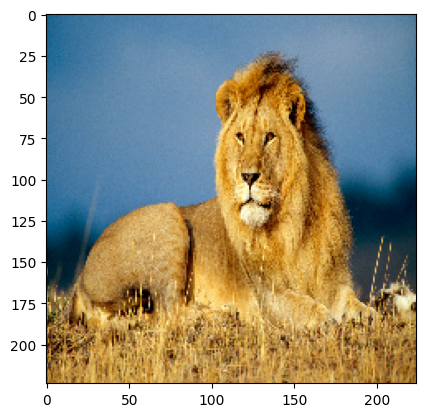

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

def get_image(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(image.img_to_array(img)/255)
    plt.grid(False)
    return image.img_to_array(img)

img_path = 'data/Simba.jpg'
x = get_image(img_path)

In [3]:

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# # decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

2024-11-19 15:51:38.485962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [('n02129165', 'lion', 0.99564725), ('n02130308', 'cheetah', 0.0013233833), ('n07802026', 'hay', 0.001009778)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: [('n04285008', 'sports_car', 0.8231042), ('n03100240', 'convertible', 0.07503899), ('n02974003', 'car_wheel', 0.06684515), ('n03459775', 'grille', 0.025561988), ('n04037443', 'racer', 0.0042373487), ('n03770679', 'minivan', 0.001738651), ('n02814533', 'beach_wagon', 0.0015378494), ('n04483307', 'trimaran', 0.0005192616), ('n03930630', 'pickup', 0.00032712086), ('n03670208', 'limousine', 0.00025701564)]


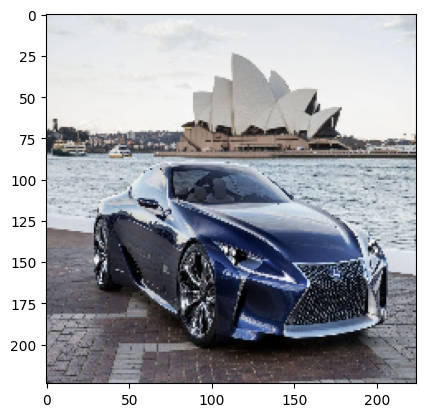

In [4]:
img_path = 'data/MyCar.jpg'
x = get_image(img_path)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=10)[0])

In [ ]:
# TODO: run on the tiny imagenet with model, to show performances

# Transfer Learning With ResNet
Let's do some learning based on the rock/paper/scissors dataset. In this example, I will use the tensorflow_datasets package for managing and dowloading the data.

In [5]:
import tensorflow_datasets as tfds

ds_train = tfds.load('rock_paper_scissors', split='train', shuffle_files=True)
ds_test = tfds.load('rock_paper_scissors', split='test', shuffle_files=False)

In [6]:
for element in ds_train.take(1):
    print(element['image'].shape)
    print(element['label'].numpy())

(300, 300, 3)
1


2024-11-19 15:51:44.943611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


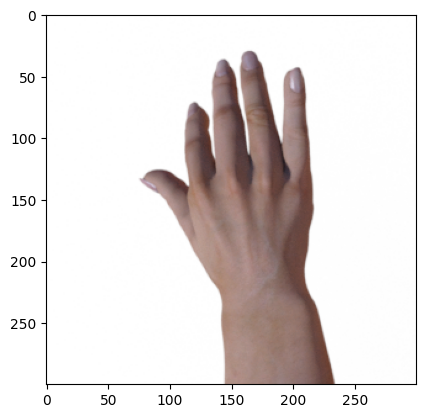

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(element['image'].numpy())
plt.grid(False)

In [8]:
# connect new layers to the output
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tensorflow as tf
import numpy as np

# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = element['image'].numpy()
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CPU times: user 1.25 s, sys: 167 ms, total: 1.42 s
Wall time: 1.59 s


(1, 10, 10, 2048)

In [9]:
x=preprocess_input(tf.expand_dims(element['image'], axis=0))
preds = res_no_top.predict(x)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 10, 10, 2048)

In [10]:
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Input, Dense
from tensorflow.keras.models import Model

NUM_CLASSES = 3

# let's add a fully-connected layer
input_x = Input(shape=preds.shape[1:])

x = SeparableConv2D(filters=32,
               kernel_size=(3,3),
               #kernel_initializer='he_uniform', 
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(input_x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dense(100, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=input_x, outputs=predictions)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 10, 2048)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 10, 10, 32)     │        84,000 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        80,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,403 (642.20 KB)

 Trainable params: 164,403 (642.20 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# map the data such that we preprocess the data 
# ds_train_map = ds_train.batch(32, drop_remainder=True)
# ds_train_map = ds_train_map.prefetch(32)

# ds_train = ds_train.batch(batch_size=tf.data.AUTOTUNE, drop_remainder=True)
preprocessed_ds_train = ds_train.map(lambda element: (res_no_top(preprocess_input(tf.expand_dims(element['image'], axis=0))), element['label']), 
                                     num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


preprocessed_ds_test = ds_test.map(lambda element: (res_no_top(preprocess_input(tf.expand_dims(element['image'], axis=0))), element['label']), 
                                     num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# preprocessed_ds_test = ds_test.map(lambda x, y: (res_no_top(x), y), 
#                                      num_parallel_calls=tf.data.AUTOTUNE)
# preprocessed_ds_test = preprocessed_ds_test.prefetch(tf.data.AUTOTUNE)

# ds_test_map = ds_test.batch(32, drop_remainder=True)
# ds_test_map = ds_test_map.prefetch(32)


In [19]:
%%time

opt = Adam() #default optimizer parameters
num_epochs = 5

# convert to tf tensor from Keras Variable for watch
trainable_variables_as_tf = [tmp.value for tmp in model.trainable_variables]

for e in range(num_epochs):
    # iterating over this is one full epoch
    for features, label in preprocessed_ds_train:
        # now the features and labels are for one batch
        with tf.GradientTape(watch_accessed_variables=False, persistent=False) as tape:
            # only watch the variables for this smaller model, to save time
            tape.watch(trainable_variables_as_tf)
            
            # run through the pre-trained processor
            #images = preprocess_input(element['image'])
            
            # and place through the pre-trained model
            #features = res_no_top(images)
            
            # put through the custom model
            yhat = model(features)
            
            # get the loss function
            # notice that the label is an integer, yhat is a vector
            # the 'sparse' keyword makes this the function expectation
            loss = sparse_categorical_crossentropy(tf.squeeze(label), tf.squeeze(yhat))
                        
        # update via auto diff and specified optimizer
        # only update the model head here
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        
    print(f'Finished epoch {e}')
       

2024-11-19 17:45:19.221387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished epoch 0


2024-11-19 17:48:10.898645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished epoch 1


2024-11-19 17:51:15.851218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished epoch 2


2024-11-19 17:54:29.791005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Finished epoch 3
Finished epoch 4
CPU times: user 1h 23min 40s, sys: 15min 1s, total: 1h 38min 41s
Wall time: 15min 28s


2024-11-19 17:57:52.391495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [36]:
num_points = 0
num_correct = 0

for features, label in preprocessed_ds_test:
    # run through the pre-trained processor
    #images = preprocess_input(element['image'])
    # and place through the pre-trained model
    #features = res_no_top(images)
    # put through the custom model
    yhat = model(features)

    # get the total batch number
    num_points += features.shape[0]

    # convert model output to an integer
    yhat = np.argmax(yhat.numpy(),axis=1)

    num_correct += sum([np.squeeze(yhat)==label.numpy()])
    
num_correct / num_points

2024-11-19 20:19:10.515983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.8682795698924731

# Deprecated Section

_____
_____
**Self Test: Should we do this Live?**

- A. Yes.
- B. No.
- C. It Depends
- D. We're gonna do it anyway

If you have OpenCV installed, you can try this.

# Imposter Syndrome:

<img src="https://i.imgflip.com/29pmyu.jpg" width=500>


In [37]:
import cv2
import numpy as np
import time
import itertools
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

if 'res_model' not in locals():
    res_model = ResNet50(weights='imagenet')

ESC_KEY = 27

# setup some windows for viewing
cv2.namedWindow("demowin1")
cv2.startWindowThread()

# open the video card for capture
vc = cv2.VideoCapture(0)

if vc.isOpened():  # try to get the first frame
    print ("vc opened, getting first frame")
    rval, frame = vc.read()
    # this will likely fail the first time
    # the webcam often needs some time to open fully
    key = 0
else:
    print ("vc not open, exiting")
    key = ESC_KEY

while key != ESC_KEY and vc.isOpened():  # the escape key and the capture device is open
    rval, frame = vc.read()
    key = cv2.waitKey(10)

    if rval and frame is not None:
        
        frame_to_show = cv2.pyrDown(frame)  # make smaller immediately
        # grab the ROI in top left (will show later on)
        frame_down = frame_to_show[0:224,0:224]
        
        # increase contrast
        img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
        frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

        # and then remove noise
        frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,10,7,21)
# h (Optional): filter strength (luminance). Larger h value removes noise but alsoß image details
# hColor (Optional):  The same as h but for color components. 
#    For most images value equals 10 will be enough to remove noise and not distort colors
# templateWindowSize (Optional): Size in pixels of the template patch that is used to compute weights. Should be odd. 
#    Recommended value 7 pixels
# searchWindowSize (Optional): Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. 
#    Recommended value 21 pixels
        
        img = frame_down.copy() # make a copy for numpy

        x = image.img_to_array(img[:,:,::-1]) # convert to numpy
        x = np.expand_dims(x, axis=0) # add batch dimension
        x = preprocess_input(x) # apply resnet presets

        preds = res_model.predict(x, verbose=0) # get the predictions
        
        # decode the results into a list of tuples (class, description, probability)
        txt = str(decode_predictions(preds, top=3)[0])

        cv2.putText(frame_to_show, txt, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, [255, 255, 255])
        cv2.rectangle(frame_to_show, (0,0), (224,224), (255,255,255), 1)
        cv2.imshow("demowin1", frame_to_show)
    
print('releasing...')
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)
print('Done')

ModuleNotFoundError: No module named 'cv2'